In [1]:
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import os
import cv2

In [2]:
def get_files(data_path, folder):
    names = []
    folder_path = os.path.join(data_path, folder)
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        for file in os.listdir(subfolder_path):
            if file.endswith(".nrrd") and not file.endswith(".seg.nrrd"):
                names.append(os.path.join(subfolder_path, file))
    return names

Data_path = r"/kaggle/input/mri-data/Data"

Dongyang_data_names = get_files(Data_path, "Dongyang")
KiTS_data_names = get_files(Data_path, "KiTS")
Rider_data_names = get_files(Data_path, "Rider")

In [3]:
def get_image(name):
    image = sitk.ReadImage(name)
    image = sitk.GetArrayFromImage(image).T
    if image.shape[1] == 666:  #Normalize shape of data y -> 512
        image = image[:, 77:589, :]
    if "Dongyang" in name: #Normalization of background - to see more, look into data_overview.ipynb
        image = image + 1024
    else:
        image[image < 0] = 0
    return image

def resize_image(image):
    image = image.astype(np.float32)
    new_image = []
    for i in range(image.shape[2]):
        image_slice = image[:, :, i]
        new_image.append(cv2.resize(image_slice, (224, 224)))
    return np.stack(new_image, axis=-1)

def normalize_slices(image): #Normalization per slice
    for i in range(image.shape[2]):
        image_slice = image[:, :, i]
        min_val = image_slice.min()
        max_val = image_slice.max()
        if max_val > min_val: #In our dataset min_val is 0, to avoid diving by 0 we check if max_val is greater than min_Val
            image[:, :, i] = (image_slice - min_val) / (max_val - min_val)
        else: 
            image[:, :, i] = 0
    return image

def get_voxels(data_names, normalized=False):
    voxels = []
    for name in data_names:
        image = resize_image(get_image(name))
        image = normalize_slices(image) if normalized else image 
        voxels.append(image.flatten())
    result = np.concatenate(voxels)
    return result

In [4]:
Dongyang_voxels = get_voxels(Dongyang_data_names, False)
KiTS_voxels = get_voxels(KiTS_data_names, False)
Rider_voxels = get_voxels(Rider_data_names, False)

Dongyang_voxels_normalized = get_voxels(Dongyang_data_names, True) 
KiTS_voxels_normalized = get_voxels(KiTS_data_names, True)
Rider_voxels_normalized = get_voxels(Rider_data_names, True)

In [5]:
def draw_hist_subplot(rows, cols, index, voxels, title):
    plt.subplot(rows, cols, index)
    plt.hist(voxels, bins=100)
    plt.yscale('log')
    plt.title(title)
    plt.xlabel("Voxel value")
    plt.ylabel("Voxel count")

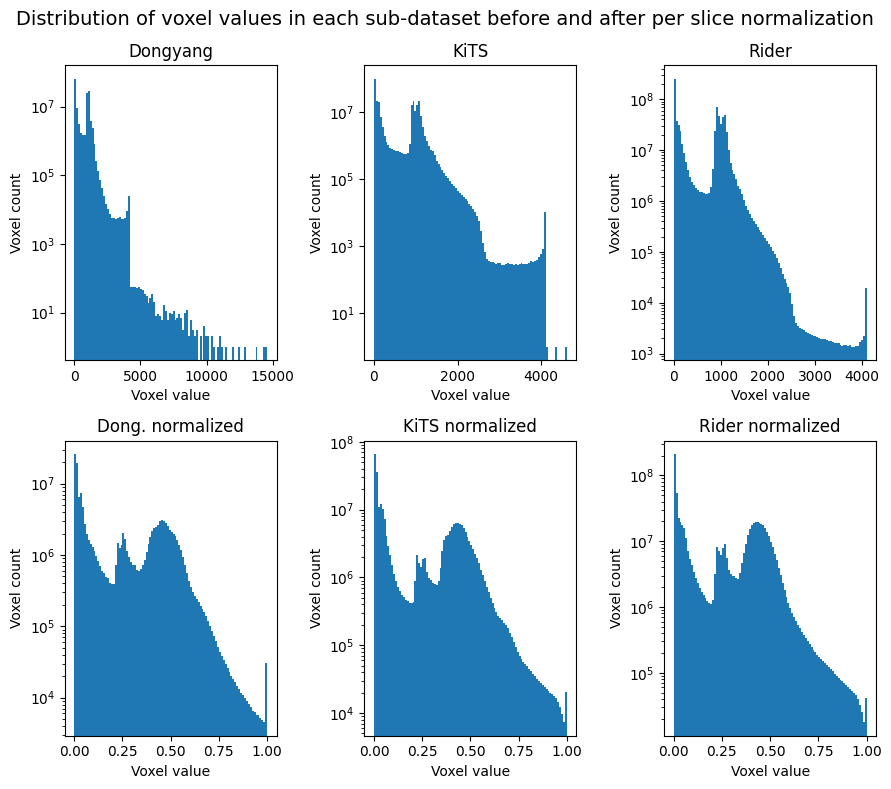

In [8]:
plt.figure(figsize=(9, 8))
plt.suptitle("Distribution of voxel values in each sub-dataset before and after per slice normalization", fontsize=14)

draw_hist_subplot(2, 3, 1, Dongyang_voxels, "Dongyang")
draw_hist_subplot(2, 3, 2, KiTS_voxels, "KiTS")
draw_hist_subplot(2, 3, 3, Rider_voxels, "Rider")

draw_hist_subplot(2, 3, 4, Dongyang_voxels_normalized, "Dong. normalized")
draw_hist_subplot(2, 3, 5, KiTS_voxels_normalized, "KiTS normalized")
draw_hist_subplot(2, 3, 6, Rider_voxels_normalized, "Rider normalized")

plt.tight_layout()
plt.show()

In [10]:
D_image = normalize_slices(resize_image(get_image(Dongyang_data_names[0])))
K_image = normalize_slices(resize_image(get_image(KiTS_data_names[17])))
R_image = normalize_slices(resize_image(get_image(Rider_data_names[2])))

print(D_image.shape)
print(K_image.shape)
print(R_image.shape)

(224, 224, 158)
(224, 224, 131)
(224, 224, 1135)


In [11]:
D_slice = D_image[:, :, 80]
K_slice = K_image[:, :, 60]
R_slice = R_image[:, :, 600]

D_slice = (D_slice*255).astype(np.uint8)
K_slice = (K_slice*255).astype(np.uint8)
R_slice = (R_slice*255).astype(np.uint8)

In [13]:
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(4, 4))
D_slice_clahe = clahe.apply(D_slice)
K_slice_clahe = clahe.apply(K_slice)
R_slice_clahe = clahe.apply(R_slice)

D_slice_mblur = cv2.medianBlur(D_slice, 3)
K_slice_mblur = cv2.medianBlur(K_slice, 3)
R_slice_mblur = cv2.medianBlur(R_slice, 3)

D_slice_all = cv2.medianBlur(D_slice_clahe, 3)
K_slice_all = cv2.medianBlur(K_slice_clahe, 3)
R_slice_all = cv2.medianBlur(R_slice_clahe, 3)

In [14]:
def draw_image_subplot(rows, cols, index, image, title):
    plt.subplot(rows, cols, index)
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off') 

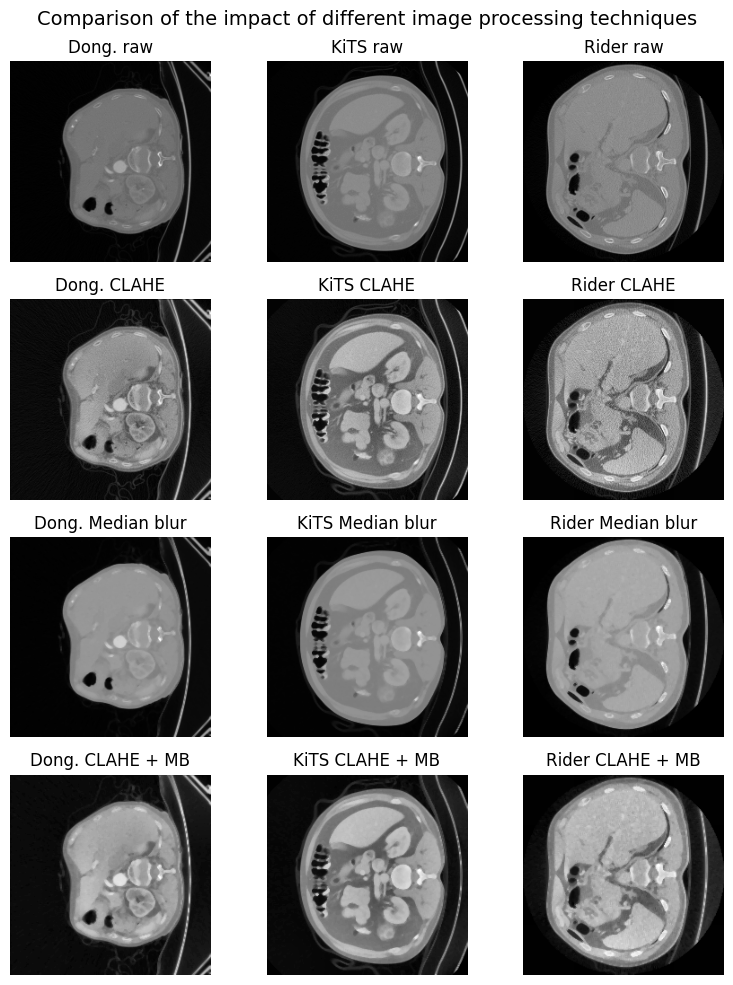

In [18]:
plt.figure(figsize=(8, 10))
plt.suptitle("Comparison of the impact of different image processing techniques", fontsize=14)

draw_image_subplot(4, 3, 1, D_slice, "Dong. raw")
draw_image_subplot(4, 3, 2, K_slice, "KiTS raw")
draw_image_subplot(4, 3, 3, R_slice, "Rider raw")

draw_image_subplot(4, 3, 4, D_slice_clahe, "Dong. CLAHE")
draw_image_subplot(4, 3, 5, K_slice_clahe, "KiTS CLAHE")
draw_image_subplot(4, 3, 6, R_slice_clahe, "Rider CLAHE")

draw_image_subplot(4, 3, 7, D_slice_mblur, "Dong. Median blur")
draw_image_subplot(4, 3, 8, K_slice_mblur, "KiTS Median blur")
draw_image_subplot(4, 3, 9, R_slice_mblur, "Rider Median blur")

draw_image_subplot(4, 3,10, D_slice_all, "Dong. CLAHE + MB")
draw_image_subplot(4, 3,11, K_slice_all, "KiTS CLAHE + MB")
draw_image_subplot(4, 3,12, R_slice_all, "Rider CLAHE + MB")

plt.tight_layout()
plt.show()